In [1]:
import findspark
findspark.init()

In [122]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql import Window

In [3]:
data_dir = 'C:/Users/John/PycharmProjects/customer-attrition/data/'

In [4]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [5]:
# building a new session
spark = SparkSession.builder.appName('data_wrangling_involved').getOrCreate()

In [6]:
# reading in the json file
user_log = spark.read.json(data_dir+'sparkify_log_small.json')

In [10]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [11]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [14]:
user_log.describe('page').show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count|  10000|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [15]:
user_log.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [16]:
# To know the number of records in the dataframe
user_log.count()

10000

In [22]:
# to see a particular column
user_log.select('length').show()

+---------+
|   length|
+---------+
|232.93342|
|195.23873|
|196.20526|
|405.99465|
|     null|
|     null|
|154.53995|
|402.93832|
|     null|
|     null|
|223.26812|
|237.11302|
|218.01751|
|237.13914|
|191.68608|
|383.58159|
|     null|
|348.57751|
|146.36363|
|238.18404|
+---------+
only showing top 20 rows



In [24]:
# to see a particular column
user_log.select('length').collect()

[Row(length=232.93342),
 Row(length=195.23873),
 Row(length=196.20526),
 Row(length=405.99465),
 Row(length=None),
 Row(length=None),
 Row(length=154.53995),
 Row(length=402.93832),
 Row(length=None),
 Row(length=None),
 Row(length=223.26812),
 Row(length=237.11302),
 Row(length=218.01751),
 Row(length=237.13914),
 Row(length=191.68608),
 Row(length=383.58159),
 Row(length=None),
 Row(length=348.57751),
 Row(length=146.36363),
 Row(length=238.18404),
 Row(length=206.00118),
 Row(length=241.42322),
 Row(length=401.78893),
 Row(length=None),
 Row(length=159.76444),
 Row(length=None),
 Row(length=219.29751),
 Row(length=226.2722),
 Row(length=282.90567),
 Row(length=289.2273),
 Row(length=163.02975),
 Row(length=None),
 Row(length=301.08689),
 Row(length=244.81914),
 Row(length=None),
 Row(length=None),
 Row(length=None),
 Row(length=196.28363),
 Row(length=320.05179),
 Row(length=281.05098),
 Row(length=None),
 Row(length=374.20363),
 Row(length=153.46893),
 Row(length=212.53179),
 Row(l

In [28]:
user_log.select('page').drop_duplicates().sort(user_log.page).show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [30]:
user_log.select(user_log.page).drop_duplicates().sort('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [31]:
user_log.select(user_log.page).drop_duplicates().orderBy('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [32]:
user_log.select(user_log.page).drop_duplicates().orderBy(user_log.page).show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [33]:
user_log.take(1)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046')]

In [34]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [39]:
user_log.select(['userId', 'firstname', 'page', 'song']).filter(user_log.userId == '1046').collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

In [43]:
user_log.select(['userId', 'firstname', 'page', 'song']).where(user_log['userId'] == 1046).collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

In [48]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)

In [49]:
user_log = user_log.withColumn('hour', get_hour(user_log.ts))

In [50]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='3')

In [59]:
songs_in_hour = user_log.filter(user_log.page == 'NextSong').groupby(user_log.hour).count().orderBy(user_log.hour.cast('float'))

In [63]:
print(songs_in_hour.show())

+----+-----+
|hour|count|
+----+-----+
|   0|  337|
|   1|  255|
|   2|  271|
|   3|  307|
|   4|  377|
|   5|  371|
|   6|  505|
|   7|  410|
|   8|  320|
|   9|  341|
|  10|  319|
|  11|  306|
|  12|  344|
|  13|  395|
|  14|  324|
|  15|  185|
|  16|  236|
|  17|  238|
|  18|  285|
|  19|  418|
+----+-----+
only showing top 20 rows

None


In [61]:
songs_in_hour_pd = songs_in_hour.toPandas()

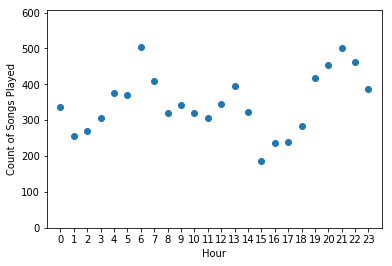

In [71]:
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd['count']));
plt.xlabel('Hour');
plt.ylabel('Count of Songs Played');

In [95]:
user_log.select('userId').drop_duplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [131]:
user_log_valid = user_log.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [132]:
print(user_log_valid.count()) # So all the records have both 'userid' and 'sessionid'. No null values in this two columns

10000


In [102]:
user_log_valid = user_log_valid.filter(user_log_valid.userId != "")

In [133]:
user_log_not_valid = user_log_valid.filter(user_log_valid.userId == "")

In [139]:
user_log_not_valid.show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+----+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|hour|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+----+
|  null|Logged Out|     null|  null|            0|    null|  null| free|    null|   PUT|Login|        null|     5598|null|   307|1513721196284|     null|      |   3|
|  null|Logged Out|     null|  null|           26|    null|  null| paid|    null|   GET| Home|        null|      428|null|   200|1513721274284|     null|      |   3|
|  null|Logged Out|     null|  null|            5|    null|  null| free|    null|   GET| Home|        null|     2941|null|   200|1513722009284|     null|      |   3|
|  n

In [147]:
user_log.select(['userId','gender']).dropDuplicates().filter("gender = 'F'").count()

462

In [148]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)



In [152]:
user_log.groupby(user_log.artist).count().sort(desc('count')).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1653|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|                Muse|   36|
|        Jack Johnson|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|               Train|   28|
|          Lily Allen|   28|
|Barry Tuckwell/Ac...|   28|
|           Metallica|   27|
|           Daft Punk|   27|
|          Nickelback|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows



In [168]:
user_log.filter(user_log.page == 'Home').count()

1126

In [103]:
print(user_log_valid.count()) 

9664


In [106]:
user_log_valid.select('page').drop_duplicates().show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|            Home|
|       Downgrade|
|          Logout|
|   Save Settings|
|           About|
|        Settings|
|        NextSong|
|            Help|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



In [111]:
user_log_valid.filter(user_log_valid['page'] == 'Submit Downgrade').show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  16|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [114]:
user_log_valid.filter(user_log_valid.page == 'Submit Downgrade').show()
# userId 1138 has gone through 'Submit Downgrade'

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  16|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [118]:
user_log_valid.select(['userId', 'firstname', 'page', 'level', 'song']).filter(user_log_valid.userId == '1138').collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [123]:
# The default type returned by udf is always a string. So if we want anything different we must use types
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType()) 

In [124]:
user_log_valid = user_log_valid.withColumn('downgraded', flag_downgrade_event('page'))

In [125]:
print(user_log_valid.head())

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='3', downgraded=0)


In [126]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding,0)

In [127]:
user_log_valid = user_log_valid.withColumn('phase', Fsum('downgraded').over(windowval))

In [128]:
print(user_log_valid.head())

Row(artist='Fabolous / The-Dream', auth='Logged In', firstName='Kevin', gender='M', itemInSession=1, lastName='Gilbert', length=231.54893, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1505550349284, sessionId=1435, song='Throw It In The Bag', status=200, ts=1513783259284, userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='1436', hour='20', downgraded=0, phase=0)


In [130]:
user_log_valid.select(['userId', 'firstname', 'ts', 'page', 'level', 'phase']).filter(user_log_valid.userId == '1138').sort('ts').collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs